In [3]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import ConcatDataset
from torchvision.utils import make_grid
import random
import numpy as np


from PIL import Image
from torch.utils.data import Dataset
import os

class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None, eval_mode=False):
        """
        Custom Dataset class for loading images.

        Parameters:
        - real_dir (str): Path to real images directory.
        - fake_dir (str): Path to fake images directory.
        - transform (callable, optional): A function/transform to apply to the images.
        - eval_mode (bool, optional): If True, skips applying transforms for raw image visualization.
        """
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.eval_mode = eval_mode
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths for the images and assign labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        
        # 0 for real, 1 for fake
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform and not self.eval_mode:
            image = self.transform(image)
        
        return image, label


In [4]:
from torchvision import transforms
from PIL import Image
import torch
import os

class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None, eval_mode=False):
        """
        Custom Dataset class for loading images.

        Parameters:
        - real_dir (str): Path to real images directory.
        - fake_dir (str): Path to fake images directory.
        - transform (callable, optional): Transformations for training.
        - eval_mode (bool, optional): If True, skips augmentations but converts images to tensors.
        """
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.eval_mode = eval_mode
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths and labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        
        # Basic transform to convert to tensor (without augmentation)
        self.basic_transform = transforms.Compose([
            transforms.ToTensor(),  # Convert PIL Image to Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        # Apply full transforms only if not in eval_mode
        if self.transform and not self.eval_mode:
            image = self.transform(image)
        else:
            image = self.basic_transform(image)  # Convert to tensor without augmentations
        
        return image, label


# **Data Augmentations**
This block of code defines the **data augmentation strategy** for training images, which helps improve the model’s robustness and generalization. 

Key changes and their purposes:
- **RandomHorizontalFlip** and **RandomVerticalFlip**: Introduce random flipping, simulating different orientations of the images.
- **RandomRotation (up to 30 degrees)**: Adds more variability by allowing larger rotations, making the model learn from diverse perspectives.
- **ColorJitter**: Adds more variance in brightness, contrast, saturation, and hue, helping the model handle different lighting conditions.
- **RandomAffine**: Slightly increases random translations and scaling, making the model more adaptable to small shifts and resizes in the image.
- **RandomResizedCrop**: Varies the size and position of the crop, simulating objects of different scales within images.

These augmentations aim to prevent overfitting by introducing a wider range of transformations, helping the model become more resilient to variations in real-world data. 
The validation and test transformations remain unchanged since augmentation is not applied during evaluation.

In [5]:
# Adjusted Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.2),  # Flip images vertically with a probability of 0.2 (new addition)
    transforms.RandomRotation(30),  # Increase rotation variability to up to 30 degrees
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # More variance in color adjustments
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Slightly more affine transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # RandomResizedCrop for more variability in object sizes
    transforms.ToTensor(),  # Converts image to tensor, scales pixel values to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# No changes needed for validation/test set as data augmentation is only for training
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **Data Loading and Training**

In [6]:
from sklearn.model_selection import train_test_split

# Define paths to your real and fake image directories
real_dir = 'final_cleaned_dataset/resized_data/rezised_real' # GAN Data has been added to this
fake_dir = 'final_cleaned_dataset/resized_data/rezised_fake' # GAN Data has been added to this

# Create the full dataset
full_dataset = ImageDataset(real_dir, fake_dir, transform=train_transform)

# Split the dataset into training (70%), validation (15%), and testing (15%)
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42, stratify=full_dataset.labels)
# Using stratification to ensure the class balance remains consistent between the training and testing sets.
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42, stratify=[full_dataset.labels[i] for i in test_indices]) 

# Create Subsets for train/val/test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Load the pretrained ViT model for binary classification
processor = AutoImageProcessor.from_pretrained("microsoft/swin-small-patch4-window7-224")
model = AutoModelForImageClassification.from_pretrained("microsoft/swin-small-patch4-window7-224")

# Move the model to the GPU if available (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(device)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


mps


In [ ]:
for name, param in model.named_parameters():
    print(name)

### **What This Code Does**

- **Unfreezing Specific Layers**:
  ```python
  if any(layer in name for layer in ['swin.encoder.layers.2', 'swin.encoder.layers.3', 'classifier']):
      param.requires_grad = True  # Allow these layers to be trained
  ```
  - **`swin.encoder.layers.2`** and **`swin.encoder.layers.3`**: These correspond to **Stage 3 and Stage 4** of the Swin Transformer.
    - These stages capture **high-level features** and are unfreezed to fine-tune them for your deepfake detection task.
  - **`classifier`**: The classification head is untrained for your binary classification task, so it’s also fine-tuned.

- **Freezing Other Layers**:
  ```python
  else:
      param.requires_grad = False  # Freeze earlier layers
  ```
  - This freezes the **embedding layers** and **Stages 1 and 2** (`swin.encoder.layers.0` and `swin.encoder.layers.1`).
    - These contain **low-level and mid-level features**, which are typically generic and transferable across tasks.

---

### **Why This Approach?**
1. **Freeze Early Layers (Stages 1 & 2)**:
   - These layers extract generic features like edges, textures, and simple patterns.
   - Freezing them reduces computational cost and helps retain the pretrained knowledge from ImageNet.

2. **Fine-Tune Later Layers (Stages 3 & 4)**:
   - These layers learn more task-specific, high-level features.
   - Unfreezing them allows the model to adapt to the nuances of deepfake detection.

3. **Fine-Tune the Classifier**:
   - The classification head needs to learn from scratch because your task involves binary classification (real vs. fake).

---

### **Comparison to ViT**
- In ViT, you unfreeze the **last 6 encoder layers**.
- In Swin, you're unfreezing **Stages 3 and 4**, which functionally correspond to the **last layers** in Swin's hierarchical design.

---

### **Outcome**
This setup ensures:
- The model leverages **pretrained generic features** from early stages.
- The **task-specific layers** are fine-tuned to improve performance for your deepfake detection task.

In [ ]:
for name, param in model.named_parameters():
    if any(layer in name for layer in ['swin.encoder.layers.2', 'swin.encoder.layers.3', 'classifier']):
        param.requires_grad = True  # Unfreeze last two stages and classifier
    else:
        param.requires_grad = False  # Freeze earlier layers


In [ ]:
def train_model(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=10,    # Number of epochs to train for
    patience=12,      # Early stopping patience
    model_save_path='best_swin_model.pth'  # Path to save the best model
):
    """
    Trains a given PyTorch model using training and validation data loaders.

    The function:
    - Implements partial fine-tuning by applying different learning rates to specific layers.
    - Utilizes dynamic learning rate scheduling based on validation loss.
    - Monitors validation recall to save the best-performing model.
    - Includes early stopping if no improvement in validation recall for a specified number of epochs.
    - Visualizes the training and validation loss and accuracy over epochs.

    Returns:
        torch.nn.Module: The trained model loaded with the best weights based on validation recall.
    """
    # Define the optimizer with different learning rates for specific Swin layers
    optimizer = optim.AdamW([
        {'params': model.swin.encoder.layers[2].parameters(), 'lr': 1e-5},  # Fine-tune stage 2
        {'params': model.swin.encoder.layers[3].parameters(), 'lr': 1e-5},  # Fine-tune stage 3
        {'params': model.classifier.parameters(), 'lr': 1e-4}              # Fine-tune classifier
    ])

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_recall = 0.0  # To track the model with the best recall
    best_epoch = 0         # To track the best epoch for early stopping
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with tqdm progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images).logits
                loss = loss_fn(val_outputs, val_labels)

                # Track validation loss and accuracy
                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                # Collect labels and predictions for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        # Calculate average validation loss and accuracy
        epoch_val_loss = val_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculate precision, recall, f1 using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
        print(f'Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1-Score: {f1:.4f}')

        # Dynamic LR adjustment based on validation loss
        scheduler.step(epoch_val_loss)

        # Save the model if it has the best recall
        if recall > best_val_recall:
            best_val_recall = recall
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved best model with validation recall: {best_val_recall:.4f}')
            early_stopping_counter = 0  # Reset early stopping counter if improvement
        else:
            early_stopping_counter += 1  # No improvement, increment counter

        # Early stopping
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs of no improvement.")
            break

    print(f"Best model saved from epoch {best_epoch} with recall: {best_val_recall:.4f}")

    # Visualize loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load the best model before returning
    model.load_state_dict(torch.load(model_save_path))
    return model

In [ ]:
def train_model_both_metrics_tracking(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=100,   # Number of epochs to train for
    patience=12,      # Early stopping patience
    model_save_path='model_epoch',  # Path prefix to save models per epoch
    best_recall_model_path='best_swin_model_recall.pth',  # Best recall model path
    best_f1_model_path='best_swin_model_f1.pth'          # Best F1 model path
):
    """
    Trains a PyTorch model using training and validation data loaders.

    Saves the best model based on validation recall and F1-score.
    Also saves models from every epoch for later inspection.

    Returns:
        dict: Metrics for each epoch.
    """

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Track best metrics
    best_recall = 0.0
    best_f1 = 0.0
    early_stopping_counter = 0
    metrics_history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        metrics_history['train_loss'].append(train_loss)
        metrics_history['train_accuracy'].append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images).logits
                loss = loss_fn(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        metrics_history['val_loss'].append(val_loss)
        metrics_history['val_accuracy'].append(val_accuracy)
        metrics_history['val_precision'].append(precision)
        metrics_history['val_recall'].append(recall)
        metrics_history['val_f1'].append(f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        print(f'Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1-Score: {f1:.4f}')

        # Save model every epoch
        epoch_model_path = f"{model_save_path}_{epoch+1}.pth"
        torch.save(model.state_dict(), epoch_model_path)
        print(f'Saved model for epoch {epoch+1}: {epoch_model_path}')

        # Save best recall model
        if recall > best_recall:
            best_recall = recall
            torch.save(model.state_dict(), best_recall_model_path)
            print(f'Saved best recall model: {best_recall_model_path} (Recall: {best_recall:.4f})')

        # Save best F1 model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_f1_model_path)
            print(f'Saved best F1 model: {best_f1_model_path} (F1-Score: {best_f1:.4f})')

        scheduler.step(val_loss)

        # Early stopping check
        if epoch > 0 and recall <= metrics_history['val_recall'][-2]:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs of no improvement.")
                break
        else:
            early_stopping_counter = 0

    # Print final best metrics
    print("Training complete!")
    print(f"Best Recall Model: {best_recall_model_path} with Recall: {best_recall:.4f}")
    print(f"Best F1 Model: {best_f1_model_path} with F1-Score: {best_f1:.4f}")

    return metrics_history


In [ ]:
# Output the sizes of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

### **Vision Transformer (ViT) Architecture**
1. **Basic Structure**:
   - **Flat Sequence of 12 Encoder Layers**:
     - ViT has a single-stage architecture with 12 encoder layers stacked sequentially.
     - Each encoder layer consists of:
       - Multi-Head Self-Attention (MHSA)
       - Feed-Forward Network (FFN)
       - Layer Normalization and Skip Connections

   - **Patch Embeddings**:
     - Input images are split into fixed-size patches (e.g., 16x16) and embedded into a sequence of tokens.
   
   - **Classifier Head**:
     - After the encoder layers, a classification head processes the final sequence output for the prediction task.

---

### **What We Changed in ViT**:
- **Frozen Early Encoder Layers**:
  - You froze the first **6 encoder layers** to retain generic feature extraction.
- **Fine-Tuned Last 6 Encoder Layers**:
  - You allowed the last **6 encoder layers** to learn task-specific features (deepfake detection).
- **Fine-Tuned Classifier Head**:
  - The classifier head was fine-tuned for binary classification (real vs. fake).

---

### **Swin Transformer Architecture**
1. **Basic Structure**:
   - **Hierarchical Design with 4 Stages**:
     - Swin has a **hierarchical structure**, reducing spatial resolution and increasing feature richness across stages.
       - **Stage 1**: High-resolution, low-level features.
       - **Stage 2**: Mid-level features.
       - **Stage 3**: High-level, task-specific features.
       - **Stage 4**: Global features.
   
   - **Window-based Self-Attention**:
     - Self-attention is applied locally within non-overlapping windows, reducing computation.
     - Shifted windows in alternate layers allow information exchange across windows.

   - **Patch Merging**:
     - Between stages, patches are merged to reduce resolution and increase feature dimension.

   - **Classifier Head**:
     - Similar to ViT, a classification head is applied after the final stage for prediction.

---

### **What We Are Changing in Swin Transformer**:
- **Freezing Early Stages (1 & 2)**:
  - These correspond to **low- and mid-level feature extraction** layers (like frozen early encoder layers in ViT).
  - Freezing these stages ensures Swin retains its **pretrained generic features** from ImageNet.

- **Fine-Tuning Later Stages (3 & 4)**:
  - These correspond to **task-specific high-level feature extraction**.
  - By fine-tuning these, you allow Swin to adapt to **deepfake detection nuances** (e.g., subtle inconsistencies in manipulated images).

- **Fine-Tuning Classifier Head**:
  - Like ViT, the classifier is fine-tuned to handle binary classification (real vs. fake).

---

### **Comparison of Changes: ViT vs. Swin**

| **Aspect**                  | **ViT (Before)**                        | **ViT (After Changes)**                     | **Swin Transformer (Before)**              | **Swin Transformer (After Changes)**       |
|-----------------------------|------------------------------------------|---------------------------------------------|--------------------------------------------|--------------------------------------------|
| **Architecture**            | Flat sequence of 12 encoder layers       | Same structure                              | 4 hierarchical stages                      | Same structure                             |
| **Feature Extraction**      | Generic features in early layers         | Retained by freezing first 6 layers         | Generic features in early stages (1 & 2)   | Retained by freezing Stages 1 & 2          |
| **High-Level Features**     | Last 6 encoder layers (task-specific)    | Fine-tuned                                  | Stages 3 & 4 (task-specific)               | Fine-tuned                                 |
| **Classifier Head**         | Fully connected (ImageNet classes)       | Fine-tuned for binary classification        | Fully connected (ImageNet classes)         | Fine-tuned for binary classification       |
| **What’s Frozen?**          | First 6 encoder layers                  | Early features frozen (transfer learning)   | Stages 1 & 2 (low/mid-level)               | Early stages frozen                        |
| **What’s Fine-Tuned?**      | Last 6 encoder layers, classifier       | Task-specific layers and classifier         | Stages 3 & 4, classifier                   | Task-specific stages and classifier        |

---

### **Summary of Key Differences**
- **ViT**: A flat sequence of encoder layers, where you froze early layers and fine-tuned the last 6 layers + classifier.
- **Swin Transformer**: A hierarchical structure, where you freeze **Stages 1 & 2** (generic features) and fine-tune **Stages 3 & 4** + classifier for task-specific learning.

In [ ]:
# Define number of epochs and model save path
num_epochs = 100
model_save_path = 'swin_best_trial_2'  # Path to save the best model

# Call the train_model function
trained_model = train_model_both_metrics_tracking(
    model=model,              # Your initialized Swin Transformer model
    train_loader=train_loader,  # DataLoader for the training set
    val_loader=val_loader,      # DataLoader for the validation set
    device=device,              # Device (cpu, mps, or cuda)
    num_epochs=num_epochs,      # Number of epochs
    model_save_path=model_save_path  # Path to save the best model
)

In [8]:
# Load the saved model
model.load_state_dict(torch.load('best_swin_model_f1.pth'))
model.eval()  #

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [9]:
# Testing loop to evaluate on the test dataset
all_test_labels = []
all_test_predictions = []
all_test_probabilities = []
test_loss = 0.0
test_correct_predictions = 0
test_total_samples = 0
# Define loss function again for testing
loss_fn = nn.CrossEntropyLoss()

In [10]:
# Define the function to evaluate the model and visualize results
def evaluate_and_visualize_model(model, test_loader, device):
    """
    Evaluates a trained model on a test dataset and computes performance metrics.

    The function:
    - Runs a forward pass on the test dataset to calculate loss, accuracy, precision, recall, F1 score, and ROC-AUC.
    - Collects true labels, predicted labels, and probabilities to compute evaluation metrics.
    - Displays a confusion matrix.
    - Returns a dictionary containing various performance metrics for further analysis.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the evaluation on (cpu, mps, or cuda).

    Returns:
        dict: A dictionary containing test loss, accuracy, precision, recall, F1 score, ROC-AUC, confusion matrix, 
            true labels, predicted labels, and probabilities.
    """

    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0
    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []

    # Define a loss function (assuming CrossEntropyLoss was used during training)
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to compute gradients during testing
        for test_images, test_labels in tqdm(test_loader, desc="Testing the model"):
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images).logits
            test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
            loss = loss_fn(test_outputs, test_labels)

            # Track loss and accuracy
            test_loss += loss.item() * test_images.size(0)
            _, test_predicted = torch.max(test_outputs, 1)
            test_correct_predictions += (test_predicted == test_labels).sum().item()
            test_total_samples += test_labels.size(0)

            # Store labels and predictions for metrics
            all_test_labels.extend(test_labels.cpu().numpy())
            all_test_predictions.extend(test_predicted.cpu().numpy())
            all_test_probabilities.extend(test_probabilities)

    # Calculate overall test loss and accuracy
    test_loss = test_loss / test_total_samples
    test_accuracy = test_correct_predictions / test_total_samples

    # Calculate precision, recall, F1 score, and ROC-AUC score
    precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average='binary')
    roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)

    # Print metrics
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}')
    print(f'Test ROC-AUC: {roc_auc:.4f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Return metrics for further use
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_labels': all_test_labels,
        'test_predictions': all_test_predictions,
        'test_probabilities': all_test_probabilities
    }

def plot_confusion_matrix(conf_matrix, class_names, save_path='confusion_matrix.png'):
    """
    Plots and saves the confusion matrix with larger, bold text for readability.

    Args:
        conf_matrix (ndarray): The confusion matrix to be visualized.
        class_names (list): List of class names for labeling the axes.
        save_path (str): Path to save the confusion matrix plot (default: 'confusion_matrix.png').

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    plt.figure(figsize=(14, 10))  # Larger figure size
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
                xticklabels=class_names, yticklabels=class_names, 
                cbar=True, annot_kws={"size": 18, "fontweight": "bold"})  # Larger and bold annotations

    plt.title("Confusion Matrix", fontsize=24, fontweight='bold')  # Larger, bold title
    plt.xlabel("Predicted Label", fontsize=20, fontweight='bold')  # Larger, bold label
    plt.ylabel("True Label", fontsize=20, fontweight='bold')  # Larger, bold label
    plt.xticks(fontsize=16, fontweight='bold', rotation=45, ha='right')  # Larger, bold ticks
    plt.yticks(fontsize=16, fontweight='bold', rotation=0)  # Larger, bold ticks

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(os.getcwd(), save_path), dpi=300)  # High-resolution save

    plt.show()

# Function to plot and save the ROC-AUC curve
def plot_roc_curve(test_labels, test_probabilities, roc_auc, save_path='roc_auc_curve.png'):
    """
    Plots and saves the ROC-AUC curve as a PNG image.

    The function:
    - Computes the false positive rate (FPR) and true positive rate (TPR) to plot the ROC curve.
    - Plots the ROC curve along with the diagonal reference line.
    - Saves the plot to the specified file path in the current directory.

    Args:
        test_labels (list): True labels from the test set.
        test_probabilities (list): Predicted probabilities for the positive class.
        roc_auc (float): Calculated ROC-AUC score for the model.
        save_path (str): Path to save the ROC-AUC curve plot (default: 'roc_auc_curve.png').

    Returns:
        None
    """

    fpr, tpr, _ = roc_curve(test_labels, test_probabilities)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save the plot
    plt.savefig(os.path.join(os.getcwd(), save_path))  # Save in current directory
    
    plt.show()

In [ ]:
# Evaluate the model and get results
results = evaluate_and_visualize_model(model, test_loader, device)

# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'], save_path='___best_swin_model_test_set_cf_f1.png')

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'], save_path='______best_swin_model_test_set_roc_f1.png')

In [11]:
# Combine val_dataset and test_dataset into a single larger dataset
combined_test_dataset = ConcatDataset([val_dataset, test_dataset])

# Create a DataLoader for the combined test dataset
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=True)

Testing the model: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Test Loss: 0.0789, Test Accuracy: 0.9660
Test Precision: 0.9644, Test Recall: 0.9678, Test F1-Score: 0.9661
Test ROC-AUC: 0.9966
Confusion Matrix:
[[1914   71]
 [  64 1921]]


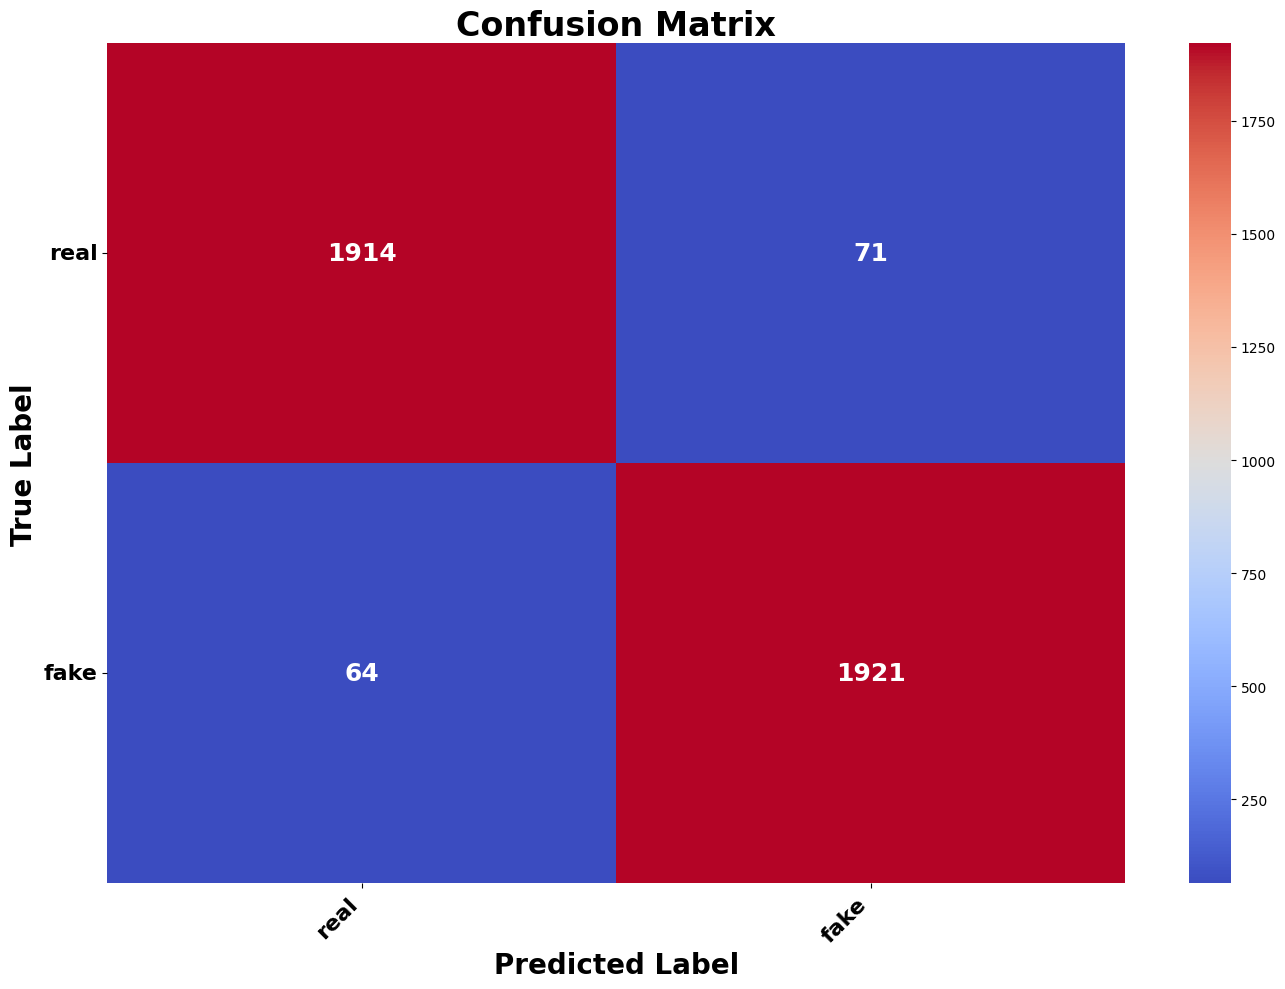

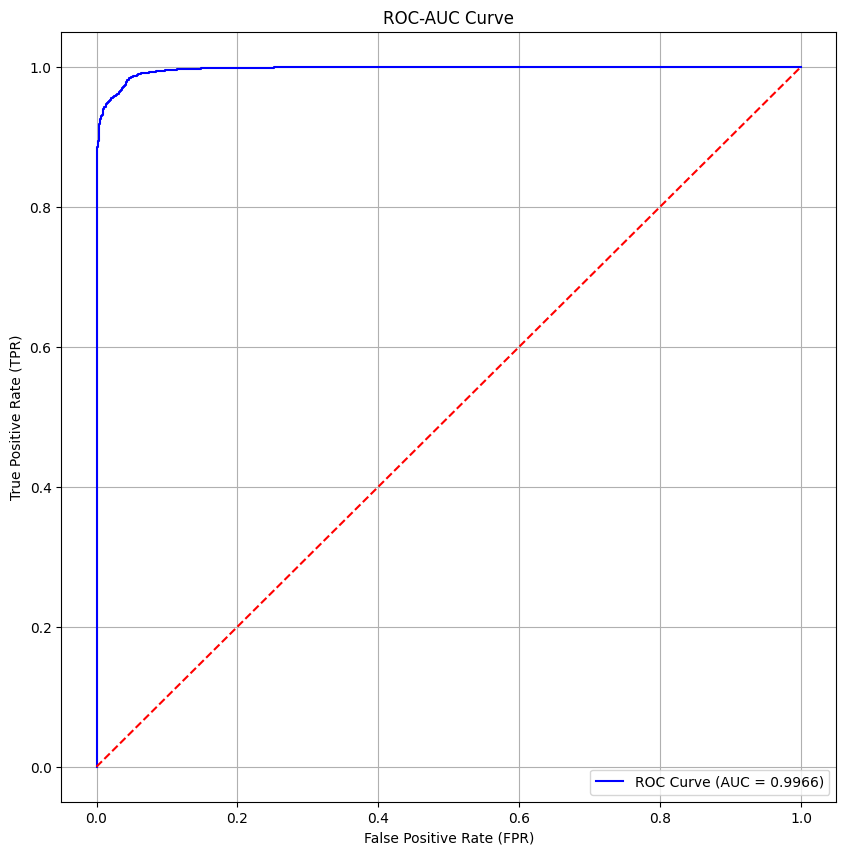

In [12]:
# Evaluate the model on the combined test set (validation + test)
results = evaluate_and_visualize_model(model, combined_test_loader, device)

# Plot the confusion matrix for the combined test set
# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'], save_path='_____best_swin_model_combined_set_cf_f1.png')

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'], save_path='______best_swin_model_combined_set_roc_f1.png')

In [ ]:
def visualize_combined_classification_results(model, combined_test_loader, device, num_images=5):
    """
    Visualizes correctly classified and misclassified images for both real and fake classes 
    from the combined test set.

    Args:
        model (torch.nn.Module): Trained model.
        combined_test_loader (DataLoader): DataLoader for the combined validation and test datasets.
        device (torch.device): Device to run inference on.
        num_images (int): Number of images to display per category.

    Returns:
        None
    """
    # Initialize lists to store images
    correct_real_images = []
    correct_fake_images = []
    misclassified_real_images = []
    misclassified_fake_images = []

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for images, labels in combined_test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits  # Handle Swin's logits output
            _, preds = torch.max(outputs, 1)

            # Move images to CPU for visualization
            images = images.cpu()

            for i in range(images.size(0)):
                image = images[i]
                label = labels[i].item()
                pred = preds[i].item()

                if pred == label:
                    # Correctly classified
                    if label == 0 and len(correct_real_images) < num_images:
                        correct_real_images.append(image)
                    elif label == 1 and len(correct_fake_images) < num_images:
                        correct_fake_images.append(image)
                else:
                    # Misclassified
                    if label == 0 and len(misclassified_real_images) < num_images:
                        misclassified_real_images.append(image)
                    elif label == 1 and len(misclassified_fake_images) < num_images:
                        misclassified_fake_images.append(image)

            # Stop once we have enough images in each category
            if (len(correct_real_images) >= num_images and
                len(correct_fake_images) >= num_images and
                len(misclassified_real_images) >= num_images and
                len(misclassified_fake_images) >= num_images):
                break

    # Visualize collected images
    categories = [
        ('Correctly Classified Real Images', correct_real_images),
        ('Correctly Classified Fake Images', correct_fake_images),
        ('Misclassified Real Images', misclassified_real_images),
        ('Misclassified Fake Images', misclassified_fake_images)
    ]

    for title, images in categories:
        if len(images) == 0:
            print(f"No images to display for {title}")
            continue
        plt.figure(figsize=(15, 5))
        for idx, image in enumerate(images):
            plt.subplot(1, num_images, idx + 1)
            imshow(image)
            plt.axis('off')
        plt.suptitle(title)
        plt.show()


In [ ]:
# Ensure eval_mode=True for loading original images
eval_dataset = ImageDataset(real_dir, fake_dir, transform=None, eval_mode=True)

combined_eval_dataset = torch.utils.data.ConcatDataset([
    torch.utils.data.Subset(eval_dataset, val_indices),
    torch.utils.data.Subset(eval_dataset, test_indices)
])

combined_test_loader = DataLoader(combined_eval_dataset, batch_size=32, shuffle=True)


import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    """
    Display an image after unnormalizing it.

    Args:
        img (Tensor): The image tensor to display.

    Returns:
        None
    """
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    # Undo normalization (assuming ImageNet stats were used)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)  # Clip values to ensure valid range
    plt.imshow(img)


In [ ]:

# Visualize images
visualize_combined_classification_results(model, combined_test_loader, device, num_images=3)